explorando uma tarefaa de regressão, predizenod valores de imóveis, usando diversões algoritmos como regressão linear, árvores de decisao e florestas aleatórias

# MNIST

In [12]:
# A Scikit-Learn fornece muitas funções auxiliares para fazer o download de conjuntos de dados populares. O MNIST é um deles. O código 
# a seguir obtém o conjunto de dados do MNIST:

# ATENÇÃO: desde o Scikit-Learn 0.24, fetch_openml() retorna um Pandas DataFrame por padrão. 
#Para evitar isso e manter o mesmo código do livro, usamos as_frame=False.

from sklearn.datasets import fetch_openml
mnsit = fetch_openml('mnist_784', version = 1, as_frame=False)
mnsit.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [26]:
# uma chave DESCR que descreve o conjunto de dados.
# Uma chave DATA que contém um array com uma linha por instância e uma coluna por característica.
# Uma chave target que contém um array com os rótulos.

X, y = mnsit['data'], mnsit['target']
print(X.shape)
print(y.shape)


(70000, 784)
(70000,)


Existem 70 mil imagens e cada uma delas apresenta 784 características. Isso ocorre porque cada imagem tem 28x28 pixels, e cada característica representa simplesmente a intensidade de um pixel, de 0(branco) a 255(preto). Vamos dar uma espiada em um algarismo do conjunto de dados. Tudo que precisamos fazer é pegar o vetor de caractrística de uma instância, remodelá-lo em um array de 28x28 e exibi-lo usando a função imshow() da Matplotlib:

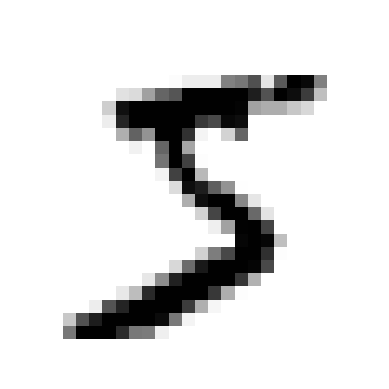

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [28]:
# o algarismo parece com um 5, e é justamente isso que o rótulo informa: 
print('rótulo = ', y[0])

#Repare que o rótulo é uma string. a maioria dos algoritmos que aprendizado de maquina espera números, logo convertemos y para inteiro:
import numpy as np
y = y.astype(np.uint8)

rótulo =  5


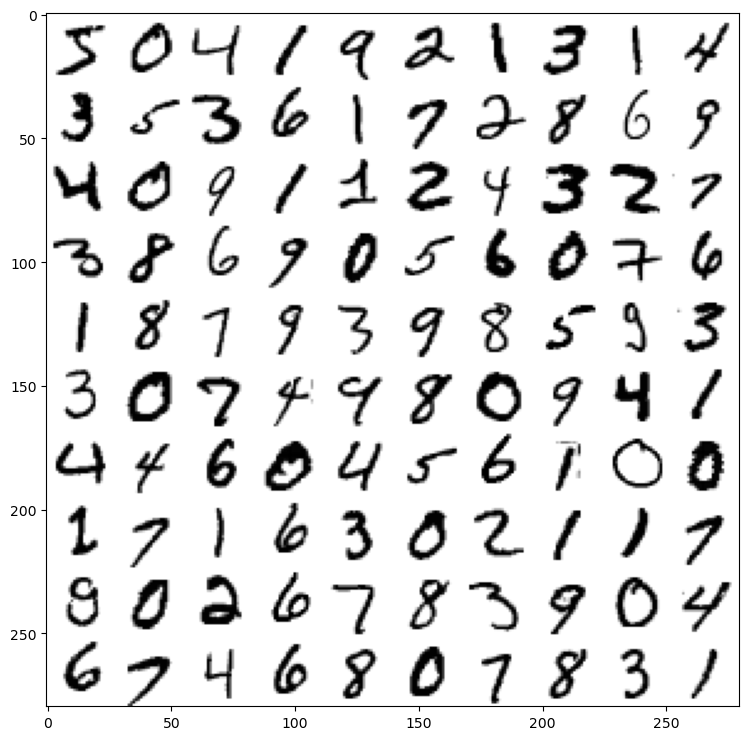

In [29]:
# EXTRA PARA GERAR ALGUMAS IMAGENS DO CONJUNTO DE DADOS MNIST.

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # Isso é equivalente a n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Anexe imagens vazias para preencher o final da grade, se necessário:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reformule a matriz para que fique organizada como uma grade contendo imagens 28×28:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine os eixos 0 e 2 (eixo de grade de imagem vertical e eixo de imagem vertical),
    # e eixos 1 e 3 (eixos horizontais). Primeiro precisamos mover os eixos que
    # queremos combinar um ao lado do outro, usando transpose(), e só então
    # pode remodelar:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)

    # Agora que temos uma imagem grande, só precisamos mostrá-la:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)

plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

In [30]:
# SEPARANDO EM TREINO E TESTE !
# treino (as 60 mil primeiras imagens ) e treino (as 10 mil ultimas imagens)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# obs: base já embaralhada!

Treinando um classificador Binário

In [32]:
# para simplificar nesse exemplo tentamos identificar apenas uma observação, o número '5'. Que será uma exemplo de classificador 
# binário capas de fazer distribuições em apenas duas classes 5 e não-5

y_train_5 = (y_train == 5) #True para todos os 5s, False para todos as outras obserações. 
y_test_5 = (y_test == 5)

In [34]:
# escolhendo um classificar e treinando !
# usando o gradiente classificador estocástico(SGD) pois ele consegui lidar eficientemente com conjunto de dados muito grandes.
#SGD lida com instâncias de treinamento de forma independentes, uma de cada vez. 

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier( random_state=42)
sgd_clf.fit(X_train, y_train_5)

# -> o SGDClassifier depende da aleatoriedade durante o treinamento(por isso, o nome "estocástico"). Para resultados que possam ser 
# reproduzidos, deina o parâmetro random_state.

SGDClassifier(random_state=42)

In [35]:
# agora, podemos usá-lo para detectar imagens de número 5: 
sgd_clf.predict([some_digit])

array([ True])

### Cálculo de Desempenho

In [41]:
#VALIDAÇÃO CRUZADA 

#avaliando o modelo com o método k-fold de validação cruzada em três partes
# -> isso significa dividir o conjunto de treinamento em k-fold (nesse caso 3), depois prever e avaliar as predição de cada um. 

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Medindo a precisão usando a validação cruzada

In [42]:
# VALIDAÇÃO CRUZADA SEM USAR 'cross_val_score'  - SEGUNDA FORMA DE FAZER

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


Observação: **shuffle=True** foi omitido por engano em versões anteriores do livro.

In [45]:
# MATRIZ DE CONFUSÃO

# realizando as predições 
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# realizando a matriz de confusão
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

 ou seja, 687 foiclassificado errado as imagem com 5  e  1891 observações foi classificado errado as imagem com não-5 !

 -> Um classificador perfeito teria somente verdadeiros positivos e verdadeiros negativos, ou seja, sua matriz de confusão teria valores diferentes de zero apenas em sua diagonal principal (da esquerda superior para a direita inferior)

### Precisão e revocação 

In [48]:
#A scikit-learn fornece diversar funções para calcular métrcias classificadoras, incluindo precisão e revocação:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
print("primeiro resultado, precision_score = ",precision_score(y_train_5, y_train_pred) )

#precisão apartir da matriz e confusão
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])
print("segundo resultado, precisão apartir da matriz e confusão = ", cm[1, 1] / (cm[0, 1] + cm[1, 1]))

#revocação
recall_score(y_train_5, y_train_pred)
print("terceiro resultado, revocação:", recall_score(y_train_5, y_train_pred))

primeiro resultado, precision_score =  0.8370879772350012
segundo resultado, precisão apartir da matriz e confusão =  0.8370879772350012
terceiro resultado, revocação: 0.6511713705958311


In [49]:
#É importante notar que alta revocação não garante alta precisão, e vice-versa. 
# Uma forma de balancear esses dois indicadores é o f1-score, que leva em conta tanto precisão quanto revocação.

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Ao aumentar a precisão reduz a revocação e vice-versa. isso se chama trade-off precisão/revocação. 

### Trade-off de precisão/revocação

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores